# Foreign Object Transplant as Data augmentation for Object Detection Networks


*   Inspired by mixup data augmentation, which linearly blends two images to solve the elephant-in-the-room problem.
*   Elephant in the room: altering contextual information in a frame worsens object detection performance. 
*   Key idea: Randomly transplanting foreign, out-of-context objects into training images as a form of nonlinear data augmentation should help against similar adversarial attacks and noise. 

In [ ]:
import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model, dummy_loss
from generator_tweak import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
import keras
from keras.models import load_model

def create_training_instances(
    train_annot_folder,
    train_image_folder,
    train_cache,
    valid_annot_folder,
    valid_image_folder,
    valid_cache,
    labels,
):
    # parse annotations of the training set
    train_ints, train_labels = parse_voc_annotation(train_annot_folder, train_image_folder, train_cache, labels)

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(valid_annot_folder):
        valid_ints, valid_labels = parse_voc_annotation(valid_annot_folder, valid_image_folder, valid_cache, labels)
    else:
        print("valid_annot_folder not exists. Spliting the trainining set.")

        train_valid_split = int(0.8*len(train_ints))
        np.random.seed(0)
        np.random.shuffle(train_ints)
        np.random.seed()

        valid_ints = train_ints[train_valid_split:]
        train_ints = train_ints[:train_valid_split]

    # compare the seen labels with the given labels in config.json
    if len(labels) > 0:
        overlap_labels = set(labels).intersection(set(train_labels.keys()))

        print('Seen labels: \t'  + str(train_labels) + '\n')
        print('Given labels: \t' + str(labels))

        # return None, None, None if some given label is not in the dataset
        if len(overlap_labels) < len(labels):
            print('Some labels have no annotations! Please revise the list of labels in the config.json.')
            return None, None, None
    else:
        print('No labels are provided. Train on all seen labels.')
        print(train_labels)
        labels = train_labels.keys()

    max_box_per_image = max([len(inst['object']) for inst in (train_ints + valid_ints)])

    return train_ints, valid_ints, sorted(labels), max_box_per_image

## Experiment Setup

We perform experiments on a small subset of VOC07 geared towards a living room context. A model is trained on the following classes: 
*   Bottle
*   Chair
*   DiningTable
*   Cow

In this case, the foreign object to be introduced into living room data is a cow; mirroring evaluation on elephant-in-the-room. 

In [2]:
!rm ./voc_train.pkl
!rm ./voc_valid.pkl

config_path='config.json'

with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

###############################
#   Parse the annotations 
###############################
train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
    config['train']['train_annot_folder'],
    config['train']['train_image_folder'],
    config['train']['cache_name'],
    config['valid']['valid_annot_folder'],
    config['valid']['valid_image_folder'],
    config['valid']['cache_name'],
    config['model']['labels']
)
print('\nTraining on: \t' + str(labels) + '\n')

###############################
#   Create the generators 
###############################    
train_generator = BatchGenerator(
    instances           = train_ints, 
    anchors             = config['model']['anchors'],   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = config['train']['batch_size'],
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],   
    shuffle             = True, 
    jitter              = 0.3, 
    norm                = normalize,
    nl_mixup            = 1.0
)

Seen labels: 	{'chair': 1432, 'car': 1644, 'horse': 406, 'person': 5447, 'bicycle': 418, 'cat': 389, 'dog': 538, 'head': 439, 'foot': 434, 'hand': 681, 'train': 328, 'aeroplane': 331, 'diningtable': 310, 'tvmonitor': 367, 'bird': 599, 'bottle': 634, 'motorbike': 390, 'pottedplant': 625, 'boat': 398, 'sofa': 425, 'sheep': 353, 'cow': 356, 'bus': 272}

Given labels: 	['bottle', 'chair', 'cow', 'diningtable']

Training on: 	['bottle', 'chair', 'cow', 'diningtable']



## Data Augmentation Strategy 
The data augmentation to be tested is simple: a foreign object (in this case, a cow) is randomly selected from the images contaning cows and is transplanted into the current training data sample. 

Disclaimer: Due to time and hardware constraints, we are unable to find the optimal hyperparameters for training from scratch using this augmentation. Therefore, only fine-tuning on pre-trained models is performed.

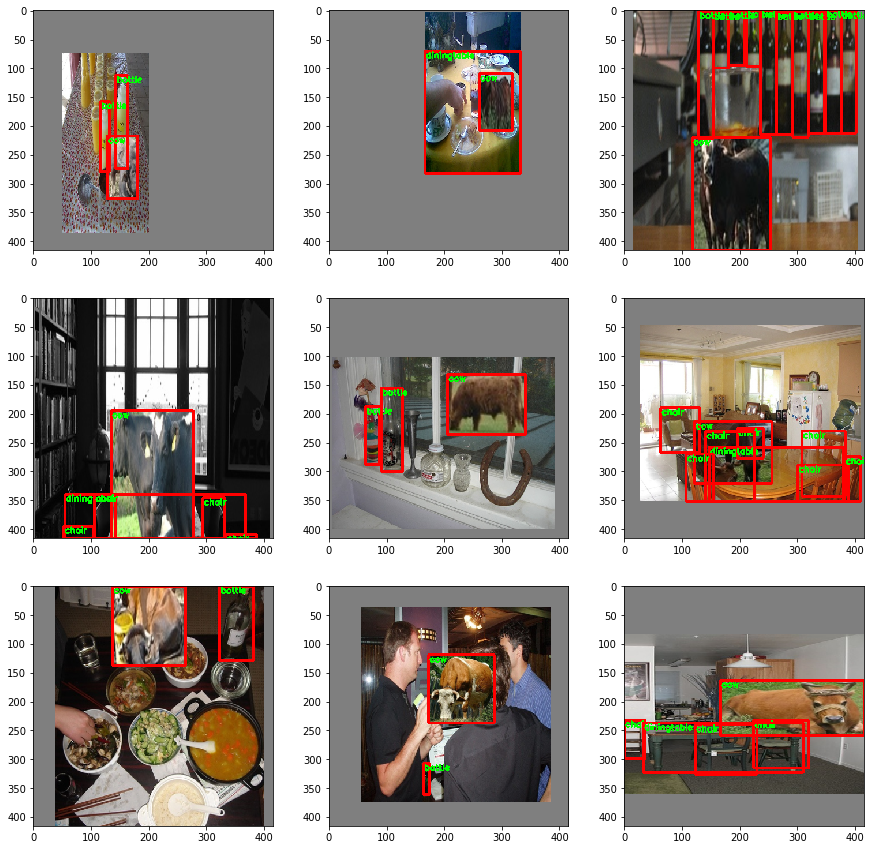

In [27]:
samples = []
for i in range(0,9):
    data, _ = train_generator.__getitem__(i)
    samples.append(data[0][0])

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib

f = plt.figure(figsize=(15,15))
for i in range(9):
    a = f.add_subplot(3,3,i+1)
    plt.imshow(samples[i], aspect='equal')
plt.show()

## Evaluation: Sliding Cow Dataset
To evaluate our data augmentation strategy, we construct a simple "sliding cow" dataset. A single .jpg cow is slid across multiple images to reproduce drop in recall found in the Elephant-in-the-Room experiments. The goal is to evaluate the effect of our data augmentation strategy on model precision, recall, and sensitivity. 

*   Precision: True_Pos / True_Pos + False_Pos
*   Recall: True_Pos / True_Pos + False_Neg
*   Sensitivity: Performance_on_SlidingCow - Performance_Original

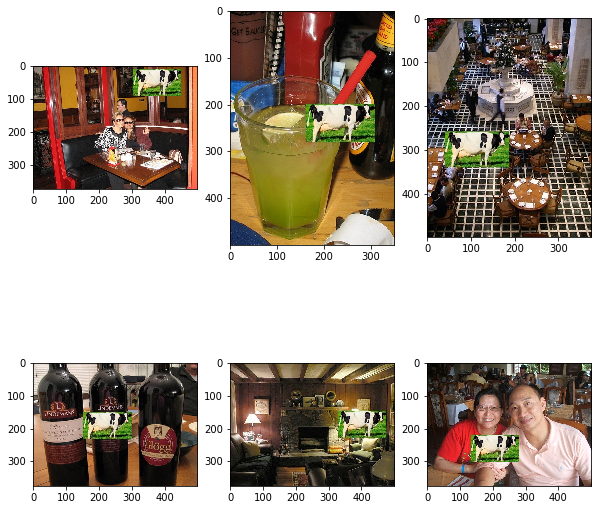

In [40]:
directory = './voc_rooms_test/aug_voc_rooms/images/'
images = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
        images.append(os.path.join(directory, filename))
        continue
    else:
        continue

#for i in images:
 # print(i)
test_samples = []
test_titles = []
for i in range(20,29):
    img = cv2.imread(images[i])
    test_samples.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    test_titles.append("test_{}".format(i))

f = plt.figure(figsize=(10,10))
for i in range(6):
    a = f.add_subplot(2,3,i+1)
    plt.imshow(test_samples[i], aspect='equal')
plt.show()

## Results

The following tables outline our results after comparing the best models trained on the original and sliding-cow dataset with and without augmentation. 

![Precision](./tables/improvement_p.PNG)
![Recall](./tables/improvement_r.PNG)

## Further Work

It can be said that the model is biased or prepared towards foreign objects it has been trained on, in this case we trained the model to be robust to cows so it makes sense for it to be have increased performance against this. Does training on ONLY a specific object (in this case, cows) transfer well to attacks using foreign objects (others)? 

To test this, we also evaluate our models on a sliding-airplane dataset and obtain the following results.

![Plane](./tables/improvement_o.PNG)

We can infer from this that the augmentation does not transfer well recall and sensitivity-wise when the foreign object is different from the augmentation object. A hypothesis can be made that using the augmentation with more objects (not just cow) might help the model to be more robust in general to other objects. 

However, we can see that it is still a viable augmentation strategy as precision has significant improvements while recall has minor improvements. 